<a href="https://colab.research.google.com/github/addieira03/pca-color-augment/blob/master/pca_color_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is PCA Color Augmentation?**

Data augmentation is the artificial enlargment of the dataset to reduce overfitting on the image data during training. The easiest and most common method to perform data augmentation is to use transformations that preserve the labels. One example is **PCA Color Augmentation**. 

PCA Color Augmentation (also called **Fancy PCA**) alters the intensities of the RGB channels along the natural variations of the images, denoted by the principal components of the pixel colors (Bargoti & Underwood, 2016). It performs Principal Components Analysis on the color channels, thus, given the name *Fancy PCA*.

![alt text](https://pixelatedbrian.github.io/img/fancy_pca/fancy_pca.png)

(Image Source: https://pixelatedbrian.github.io/2018-04-29-fancy_pca/)


The figure above shows an example of how Fancy PCA looks very natural compared to random changes in the RGB intensities. To make the intensity change more obvious to the naked eye, augmentation in this example was magnified by ~1000x. 

## **"What do I need to know before learning Fancy PCA?"**

If you have a good foundation in linear algebra, you will be able to fully grasp the algorithm of fancy PCA. 

If you are a beginner both to linear algebra and fancy PCA, here's a [playlist](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) of Youtube videos to teach you about the fundamentals of linear algebra. 

After that, read about principal component analysis (PCA). Or you can watch this [step-by-step video](https://www.youtube.com/watch?v=FgakZw6K1QQ) about PCA. 

## **How Fancy PCA works**

This method is based on the study by *Krizhevsky, Sutskever & Hinton (2012)*, the proponents of AlexNet. 

Specifically, Principal Component Analysis is performed on the set of RGB pixel values *throughout the image dataset*. To each image, multiples of the found principal components are added, with magnitudes proportional to the corresponding eigenvalues times a random variable drawn from a Gaussian distribution with mean=0 and standard deviation=0.1.





Therefore to each RGB image pixel 
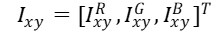
the following quantity is added: 
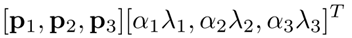

where image.png and image.png are *i*th eigenvector and eigenvalue of the 3 × 3 covariance matrix of RGB pixel values, respectively, and image.png is the aforementioned random variable. Each image.png is drawn only once for all the pixels of a particular training image until that image is used for training again, at which point it is re-drawn.

## **Step-by-step algorithm of Fancy PCA**

This algorithm is mainly based on this [Python code](https://github.com/pixelatedbrian/fortnight-furniture/blob/master/src/fancy_pca.py) for Fancy PCA (with few modifications). I used numpy and PIL libraries. 

**Step 1.** Load the image(s) as a numpy array with (h, w, rgb) shape as integers between 0 to 255



```
from numpy import asarray
from PIL import Image

im = Image.open('image.jpg') #load image.jpg
i_a = asarray(im) #convert image to array
```


**Step 2.** Convert the range of pixel values from 0-255 to 0-1 



```
i_a = i_a / 255.0
```



**Step 3.** Flatten the image to columns of RGB (3 columns)

Flattening the images merges all the layers (in this case, RGB layers) into one column each color channel.


```
img_rs = i_a.reshape(-1, 3)
```



**Step 4.** Centering the pixels around their mean (for more info, [click here](https://en.wikipedia.org/wiki/Principal_component_analysis#/media/File:GaussianScatterPCA.svg))



```
img_centered = img_rs - np.mean(img_rs, axis=0)
```




**Step 5.** Calculate the 3x3 covariance matrix using [numpy.cov](https://numpy.org/doc/stable/reference/generated/numpy.cov.html). The parameter `rowvar` is set as `False` because each column represents a variable, while rows contain the values.


```
img_cov = np.cov(img_centered, rowvar=False)
```



**Step 6.** Calculate the *eigenvalues* (3x1 matrix) and *eigenvectors* (3x3 matrix) of the 3 x3 covariance matrix using [numpy.linalg.eigh](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)



```
eig_vals, eig_vecs = np.linalg.eigh(img_cov)
```

Then, sort the eigenvalues and eigenvectors

```
sort_perm = eig_vals[::-1].argsort()
eig_vals[::-1].sort()
eig_vecs = eig_vecs[:, sort_perm]
```

After that, you will finally get eigenvector matrix [p1, p2, p3]  as:


```
m1 = np.column_stack((eig_vecs))
```



**Step 7.** Get a 3x1 matrix of eigenvalues multipled by a *random variable* drawn from a Gaussian distribution with mean=0 and sd=0.1 using [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)


One thing to note, according to Krizhevsky, Sutskever & Hinton (2012), is that the alpha should only be drawn once per augmentation (not once per channel)

```
m2 = np.zeros((3, 1))
alpha = np.random.normal(0, 0.1)
```







**Step 8.** Create and add the vector (add_vect) that we're going to add to each pixel



```
m2[:, 0] = alpha * eig_vals[:]
add_vect = np.matrix(m1) * np.matrix(m2)

for idx in range(3):   # RGB
    orig_img[..., idx] += add_vect[idx]
```



**Step 9.** Convert the range of arrays from 0-1 to 0-255 (u-int8)



```
orig_img = np.clip(orig_img, 0.0, 255.0)
orig_img = orig_img.astype(np.uint8)

return orig_img
```



**Step 10.** Convert the array of the augmented image back to jpg using [Image.fromarray](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.fromarray)



```
final_img = Image.fromarray(orig_img)
```



I tried augmenting my own image. To see the difference, I opened both images as arrays. The highlighted values are the pixels changed by the fancy PCA transformation.

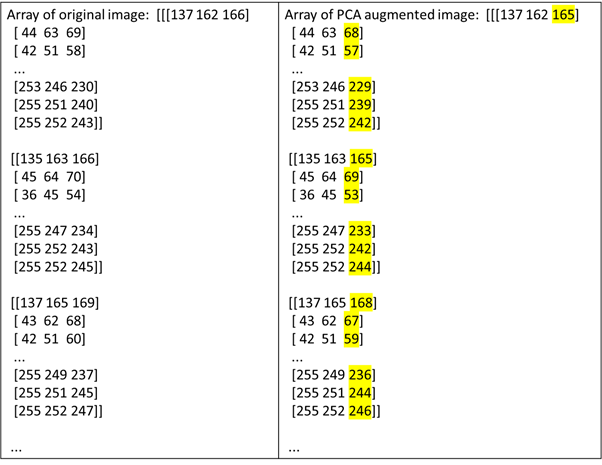

## **Fancy PCA on batch of images**

The code below is to perform fancy PCA to a batch of images in a folder to another destination folder. Try editing `path, path2` and `path3` to test your own image.

In [0]:
# Import required libraries
from numpy import asarray
import argparse
import fancy_pca
from PIL import Image
import os
import glob
import numpy as np


# Load multiple images
image_list = []
fname_list = []
path = '/content/drive/My Drive/images/orig/lori.jpg' # path of the original image dataset. 
path2 = '/content/drive/My Drive/images/orig/' # path of the original dataset folder

# Load images and put them in a list (image_list)
for infile in glob.glob(path):
    im = Image.open(infile)
    image_list.append(im)

# Extract the names of the files and put them in a list (fname_list)
base = os.listdir(path2)
for f in base:
    fname = os.path.splitext(f)
    fname_list.append(fname[0])
    print("Loading",infile)
    print(len(image_list)," images has loaded.")


# Convert images to numpy arrays
array_list =[]
n=1
for i in image_list:
    i_a = asarray(i)
    array_list.append(i_a)
    print("Image", n, ": Conversion successful.")
    n+=1
print("Array of original image: ", i_a) #To see the array

print("Conversion successful")
print(type(i_a), i_a.shape)

# Perform the PCA color augmentation
n=1
aug_list=[]
for a in array_list:
    augmented = fancy_pca.fancy_pca(a)
    aug_list.append(a)
    print("Array",n, ":Augmentation successful")
    n += 1
print("Array of PCA augmented image: ", augmented) #To see the array

# Convert Fancy PCA result back to PIL image
path3 = "/content/drive/My Drive/images/aug/" #path of the destination folder
idx=0
for aug in aug_list:
    i2 = Image.fromarray(aug)
    print(fname_list)
    while idx<= len(fname_list):
        print(str(fname_list[idx])+"_1.jpg")
        i2.save(path3+(str(fname_list[idx])+"_1.jpg"))
        break
    idx+=1
    print("Augmented image", idx, "saved.")



Loading /content/drive/My Drive/images/orig/lori.jpg
1  images has loaded.
Image 1 : Conversion successful.
Array of original image:  [[[136  99  31]
  [158 123  59]
  [160 128  71]
  ...
  [178 130  92]
  [171 123  87]
  [165 119  85]]

 [[161 124  56]
  [137 103  39]
  [134 103  46]
  ...
  [182 134  96]
  [173 127  91]
  [169 123  89]]

 [[156 123  56]
  [117  86  22]
  [125  99  42]
  ...
  [187 139 101]
  [178 132  96]
  [171 127  92]]

 ...

 [[138 126  26]
  [140 127  25]
  [147 134  32]
  ...
  [137 168  51]
  [134 168  48]
  [133 167  46]]

 [[121 109  11]
  [130 118  18]
  [143 131  31]
  ...
  [136 170  50]
  [135 169  48]
  [134 168  47]]

 [[126 116  18]
  [137 127  29]
  [149 140  39]
  ...
  [136 170  49]
  [134 170  48]
  [134 170  46]]]
Conversion successful
<class 'numpy.ndarray'> (607, 910, 3)
Array 1 :Augmentation successful
Array of PCA augmented image:  [[[135  99  30]
  [157 123  58]
  [159 128  70]
  ...
  [177 130  91]
  [170 123  86]
  [164 119  84]]

 [[160 1

## **Literature Cited**


1.   Bargoti, S., Underwood, J. (2016). Deep Fruit Detection in Orchards. Proceedings - IEEE International Conference on Robotics and Automation, 3626–3633. https://doi.org/10.1109/ICRA.2017.7989417
2.   Krizhevsky, A., Sutskever, I., Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks. In F. Pereira, C. J. C. Burges, L. Bottou, & K. Q. Weinberger (Eds.), Advances in neural information processing systems 25 (pp. 1097–1105). Curran Associates, Inc. Retrieved from https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

